In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ferrosim import Ferro2DSim
# import torch
import joblib
from joblib import Parallel, delayed, parallel_backend
import time
np.random.seed(512)
import pandas as pd
# from sklearn.model_selection import train_test_split
from scipy.stats import halfnorm, norm
import pickle

import gpax
import jax.numpy as jnp
gpax.utils.enable_x64()
import jax

/nfs/home/svalleti/anaconda3/envs/ferrosim/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [33]:
import haiku as hk

class customMLP(hk.Module):
    """Simple MLP"""
    def __init__(self, embedim=2):
        super().__init__()
        self._embedim = embedim

    def __call__(self, x):
        x = hk.Linear(32)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(32)(x)
        x = jax.nn.relu(x)
        x = hk.Linear(self._embedim)(x)
        return x

In [3]:
class CustomCNN(hk.Module):
    def __init__(self, embedim = 2, name=None):
        super().__init__(name=name)
        self._embedim = embedim

    def __call__(self, x):
        # x shape should be (batch_size, 900, 1) where 1 is the number of channels
        x = hk.Conv1D(output_channels=8, kernel_shape=3, stride=1, padding='SAME')(x)
        x = jax.nn.relu(x)
        x = hk.MaxPool(window_shape=2, strides=2, padding='VALID')(x)
        
        x = hk.Conv1D(output_channels=16, kernel_shape=3, stride=1, padding='SAME')(x)
        x = jax.nn.relu(x)
        x = hk.MaxPool(window_shape=2, strides=2, padding='VALID')(x)
        
        x = hk.Conv1D(output_channels=32, kernel_shape=3, stride=1, padding='SAME')(x)
        x = jax.nn.relu(x)
        x = hk.MaxPool(window_shape=2, strides=2, padding='VALID')(x)
        
        # Flatten the output
        x = hk.Flatten()(x)
        
        # Fully connected layer to the desired number of output neurons
        # x = hk.Linear(32)(x)
        # Fully connected layer to the desired number of output neurons
        x = hk.Linear(self._embedim)(x)
        return x

In [4]:
# Class for Genetic Algorithm 

class GA():
    def __init__(self, inputs, outputs_abs, dkl, key, gen_array):
        self.inputs = inputs
        self.outputs_abs = outputs_abs
        self.dkl = dkl
        self.key = key
        self.gen_array = gen_array
    
    def crossover(self, idx1, idx2):
        # Method to perform arithemetic crossover given two parents (par1 and par2)
        # chld1 = lambda * par1 + (1-lambda) * par2
        # chld2 = (1-lambda) * par1 + lambda * par2
        
        par1 = self.inputs[idx1]
        par2 = self.inputs[idx2]
        weight = np.random.uniform(0.15, 0.85) 
        chld1 = (weight*par1) + ((1-weight)*par2)
        chld2 = ((1-weight)*par1) + (weight*par2)
        
        return chld1, chld2, weight
    
    def mutation(self, idx):
        # Method to peform mutation
        # Adds or subtracts a Gaussian distribution with a randomly selected mean and standard deviation
        
        par = self.inputs[idx]
        mu  = np.random.choice(np.arange(100, 800))
        std = halfnorm.rvs(loc = 50, scale = 150)
        pdf = norm.pdf(np.arange(900), mu, std)
        factor = np.random.choice([-1,1])
        weight = (np.random.rand()*100)+50
        chld = par+(weight*factor*pdf)

        return chld

    def make_next_gen(self, P = [0.5, 0.5], policy = 'thompson'):

        # Method to form the next generation of the genetic algorithm
        # P is the list of porbabilitiesto perform GA operations, Currently we are only performing crossover...
        # ... and mutation and hence it is a list with two items summing to 1.

        
        # 15% of the fittest curves are carried to the next generation directly
        # The rest 85% curves are formed by performing operations governed by P where the curves are picked...
        # ... with a likelihood proportional to the fitness function

        if policy == 'thompson':
            seed = np.random.randint(0, 10000)  # This is an example; manage seeds appropriately
            new_key = jax.random.PRNGKey(seed)
            fitness = np.array(self.dkl.sample_from_posterior(new_key, self.inputs, n = 1)[1][0])
            fitness[fitness<0] = 0
            variable_fitness = True
        elif policy == 'mean':
            fitness, _ = np.array(self.dkl.predict(self.key, self.inputs))
            fitness[fitness<0] = 0
            variable_fitness = False
        elif policy == 'variance':
            _, fitness = np.array(self.dkl.predict(self.key, self.inputs))
            fitness[fitness<0] = 0
            variable_fitness = False

        
        num_carry_frwd = int(0.15*len(fitness))
        
        sorted_inds = np.argsort(fitness)[::-1]
        nextgen_X = self.inputs[sorted_inds[0:num_carry_frwd]]
        nextgen_abs = self.outputs_abs[sorted_inds[0:num_carry_frwd]]
        nextgen_gens = self.gen_array[sorted_inds[0:num_carry_frwd]]

        # picked_inds = np.random.choice(np.arange(len(self.inputs)), 
        #                                replace = True, p = self.fitness/np.sum(self.fitness), size = 950)
        
        # Identify the current generations
        current_gen = np.max(self.gen_array) + 1

        num_new_chld = len(fitness) - num_carry_frwd
        
        j = 0
        while j < num_new_chld:
            operator = np.random.choice([0, 1], p = P)
            if operator == 0:
                # Here goes crossover with 2 indices

                if variable_fitness:
                    seed = np.random.randint(0, 10000)  # This is an example; manage seeds appropriately
                    new_key = jax.random.PRNGKey(seed)
                    fitness = np.array(self.dkl.sample_from_posterior(new_key, self.inputs, n = 1)[1][0])
                    fitness[fitness<0] = 0
                
                picked_inds = np.random.choice(np.arange(len(self.inputs)), 
                                       replace = False, p = fitness/np.sum(fitness), size = 2)
                new1, new2, _ = ga.crossover(picked_inds[0], picked_inds[1])
                nextgen_X = np.append(nextgen_X, new1[None], axis = 0)
                nextgen_X = np.append(nextgen_X, new2[None], axis = 0)
                
                nextgen_abs = np.append(nextgen_abs, [np.nan, np.nan])
                nextgen_gens = np.append(nextgen_gens, [current_gen, current_gen])
                
                j+=2
            elif operator == 1:
                # Here goes the mutation

                if variable_fitness:
                    seed = np.random.randint(0, 10000)  # This is an example; manage seeds appropriately
                    new_key = jax.random.PRNGKey(seed)
                    fitness = np.array(self.dkl.sample_from_posterior(new_key, self.inputs, n = 1)[1][0])
                    fitness[fitness<0] = 0
                
                picked_inds = np.random.choice(np.arange(len(self.inputs)), 
                                       replace = False, p = fitness/np.sum(fitness), size = 1)
                new = self.mutation(picked_inds[0])
                nextgen_X = np.append(nextgen_X, new[None], axis = 0)
                nextgen_abs = np.append(nextgen_abs, np.nan)
                nextgen_gens = np.append(nextgen_gens, np.array(current_gen))

                j+=1

        return nextgen_X, nextgen_abs, nextgen_gens

In [5]:
def runferrosim(i, X, fmul = 150):
    applied_field = np.zeros([len(t_vec_ext),2])
    applied_field[0:900,0] = fmul*X[i]
    applied_field[900::,0] = applied_field[899, 0]
    sim = Ferro2DSim(n=20, time_vec = t_vec_ext, appliedE= applied_field,
                 defects=defect_list, 
                 mode = 'tetragonal', init = 'pr', k=100.0, dep_alpha = 0.3)
    sim.runSim()
    curl = np.sum(np.abs(sim.calc_curl(sim.getPmat(time_step = -1))))
    # pmat = sim.getPmat(time_step = -1)
    # np.sum(np.abs(sim.calc_curl(pmats_total[i])))
    
    del sim
    return curl

In [6]:
dataset = np.load('dataset.npy')   # 7,500 electric fields, the generation of these will be discussed below
curls = np.load('curls.npy')   # Polarization matrices at the end of FerroSIM simulations for the electric fields downloaded
defects = np.load('defect_list_seed.npy')   # Defects used in ferroSIM simulations
defect_list = list(defects)

t_vec_dummy = np.linspace(0,4,1200)
t_vec = t_vec_dummy[0:900]  #Time used in rvae  
t_vec_ext = t_vec_dummy[0:950]    #Time used in ferrosim

In [7]:
applied_field = np.zeros([len(t_vec_ext),2])
applied_field[0:900,0] = 150*dataset[512]
applied_field[900::,0] = applied_field[899, 0]   #Adding the equilibration region
np.random.seed(512)
sim = Ferro2DSim(n=20,    #Lattice size 
                 time_vec = t_vec_ext,   #Time Vector
                 appliedE= applied_field,   # Applied electric field in x and y directons
                 defects=defect_list,       # Any list of defects
                 mode = 'tetragonal',       #Mode of the free energy equations to be used, refer: https://github.com/ramav87/FerroSim/blob/rama_dev_updated/equations.docx
                 init = 'pr',       #Initialization mode, random initialization might not cause reproducibility and hence all the lattice sites are initialized to a constant value
                 k=100.0,         # coupling constant, K = k/8, where K is the coupling constant in the free energy equation
                 dep_alpha = 0.3  #Depolarization constant
                 )

sim.runSim()

---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:17<00:00, 52.79it/s]


{'Polarization': array([[   0.        ,   46.69407778,   57.63946765, ..., -225.33271619,
         -225.3687708 , -225.40668959],
        [   0.        ,    0.73501264,    0.95061945, ...,    8.7476161 ,
            8.7295951 ,    8.70882211]]),
 'dPolarization': array([[    0.        , 13996.54981398, 13778.29297494, ...,
           -62.62556612,   -59.33408458,   -55.45454149],
        [    0.        ,   220.32003826,   209.45607462, ...,
           -27.75449769,   -27.04330938,   -25.89016839]])}

Text(0.5, 1.0, '7500 datapoints')

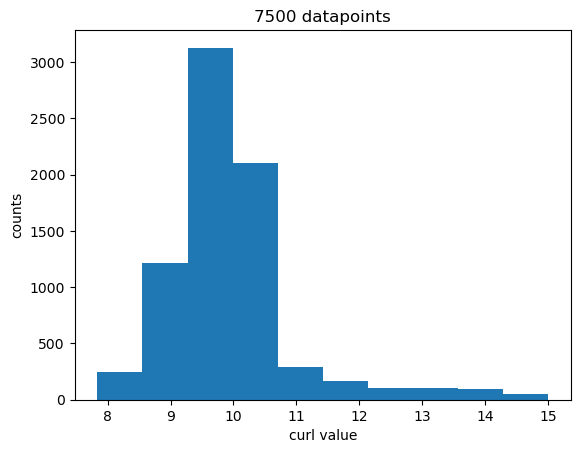

In [8]:
# Curls distribution of the entire dataset
plt.hist(curls)
plt.xlabel('curl value')
plt.ylabel('counts')
plt.title('7500 datapoints')

# Generation-0

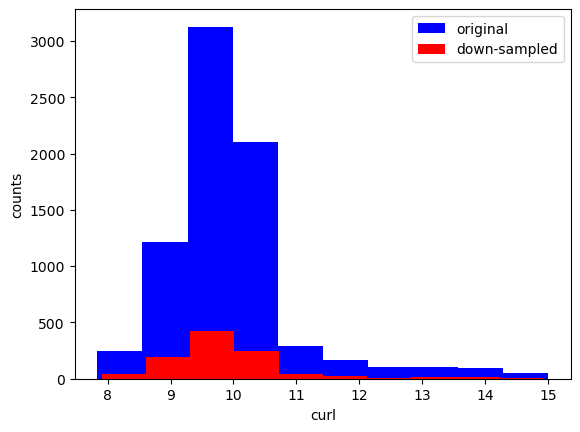

In [40]:
# np.random.seed(521)
np.random.seed(5)
dummy = np.random.choice(np.arange(len(dataset)), size = 1000, replace = False)
X0 = np.copy(dataset)[dummy]
y0_abs = np.copy(curls)[dummy]

plt.hist(curls, color = 'b', label = 'original')
plt.hist(y0_abs, color = 'r', label = 'down-sampled')
plt.xlabel('curl')
plt.ylabel('counts')
plt.legend()

In [58]:
rng_key_0, rng_key_predict_0 = gpax.utils.get_keys()
dkl_BO_0 = gpax.viDKL(900, 2, 'RBF')
np.random.seed(512)
train_inds = np.random.choice(np.arange(len(X0)), size = 1000, replace = False)
dkl_BO_0.fit(rng_key_0, X0[train_inds], y0_abs[train_inds], nn = customMLP, num_steps = 1000, step_size = 5e-3)

100%|█| 1000/1000 [03:23<00:00,  4.90it/s, init loss: 67120.3772, avg. loss [951


Inferred GP kernel parameters
k_length         [3.7644 2.3222]
k_scale          6.164000000000001
noise            0.019700000000000002


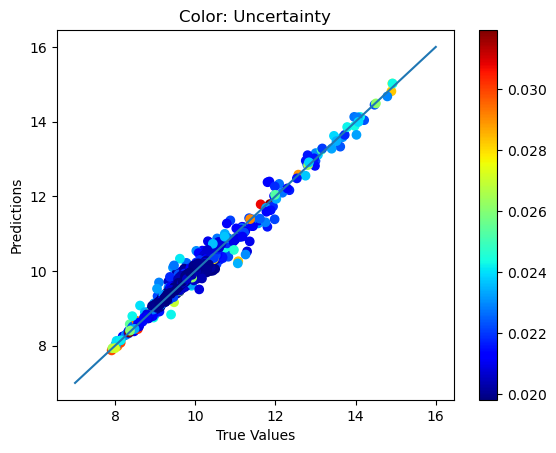

In [59]:
preds, preds_stds = dkl_BO_0.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
            rng_key_predict_0, X0, batch_size=20)
plt.scatter(y0_abs, preds, c = preds_stds, cmap = 'jet')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Color: Uncertainty')
plt.colorbar()
plt.plot(np.linspace(7, 16, 100), np.linspace(7, 16, 100))

Text(0.5, 1.0, 'Color: Uncertainty')

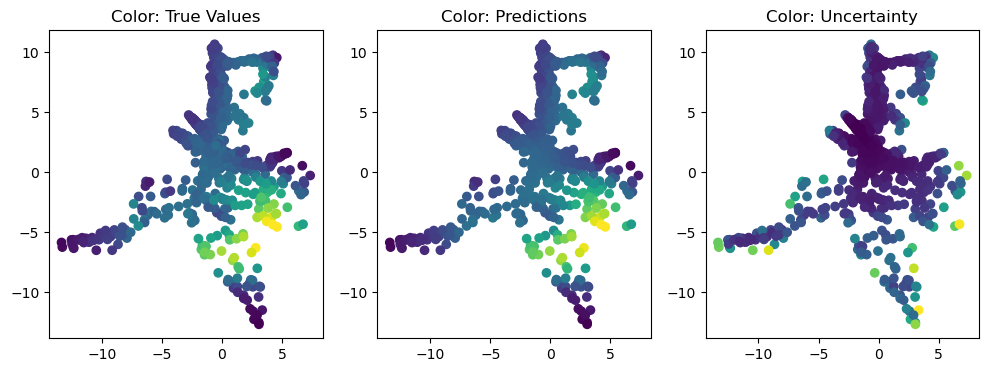

In [60]:
z = dkl_BO_0.embed(X0[train_inds])
fig, ax = plt.subplots(ncols = 3, figsize = (12, 4))
ax[0].scatter(z[:, 0], z[:, 1], c = y0_abs[train_inds])
ax[0].set_title('Color: True Values')
ax[1].scatter(z[:, 0], z[:, 1], c = preds[train_inds])
ax[1].set_title('Color: Predictions')
ax[2].scatter(z[:, 0], z[:, 1], c = preds_stds[train_inds])
ax[2].set_title('Color: Uncertainty')

Text(0.5, 1.0, 'Color: Uncertainty')

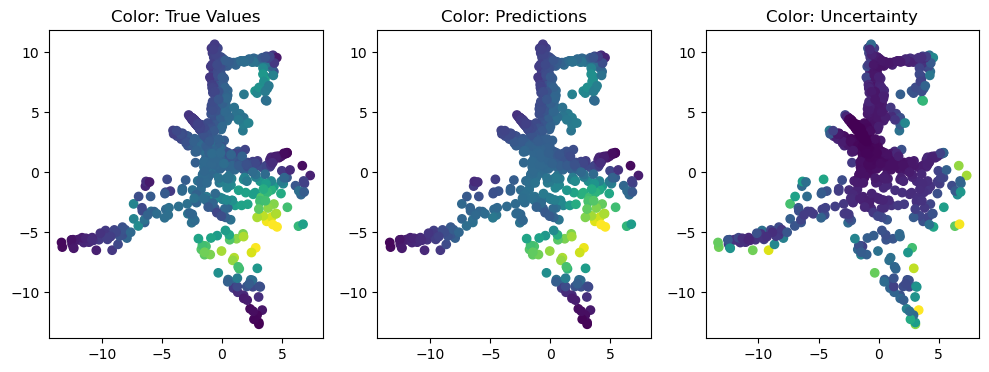

In [61]:
z = dkl_BO_0.embed(X0)
fig, ax = plt.subplots(ncols = 3, figsize = (12, 4))
ax[0].scatter(z[:, 0], z[:, 1], c = y0_abs)
ax[0].set_title('Color: True Values')
ax[1].scatter(z[:, 0], z[:, 1], c = preds)
ax[1].set_title('Color: Predictions')
ax[2].scatter(z[:, 0], z[:, 1], c = preds_stds)
ax[2].set_title('Color: Uncertainty')

In [12]:
pred_mean, pred_std = dkl_BO_0.predict(rng_key_predict_0, X0)

In [13]:
gens0 = np.zeros(len(X0))
ga = GA(X0, y0_abs, dkl_BO_0, rng_key_predict_0, gens0)
# import time
# tic = time.time()
# inps, outs, genss = ga.make_next_gen()  # Making next generation curves
# print(time.time()-tic)

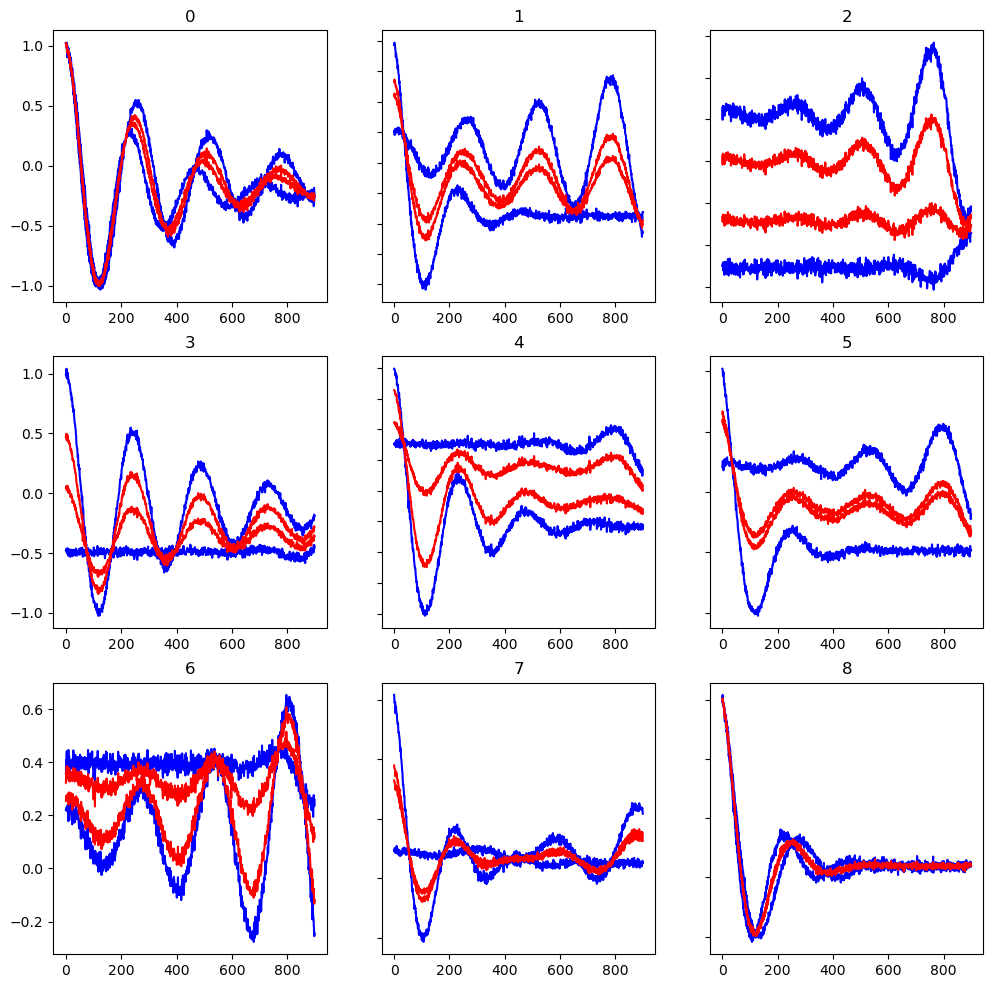

In [14]:
# Examples of Arithemetic Crossover
fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (12,12))
dummy_inds = np.random.choice(np.arange(len(X0)), size = 18)

for i, ax in enumerate(ax.flat):
    id1, id2 = dummy_inds[2*i], dummy_inds[2*i+1] 
    ax.plot(X0[id1], c = 'b')
    ax.plot(X0[id2], c = 'b')
    child1, child2, weight = ga.crossover(id1, id2)
    ax.plot(child1, c = 'r')
    ax.plot(child2, c = 'r')
    # ax.set_title(str(weight))
    ax.set_title(str(i))
    if i not in  [0, 3, 6]:
        ax.set_yticklabels([]) # x-axis
# ax[0].set_xticklabels([]) # y-axis


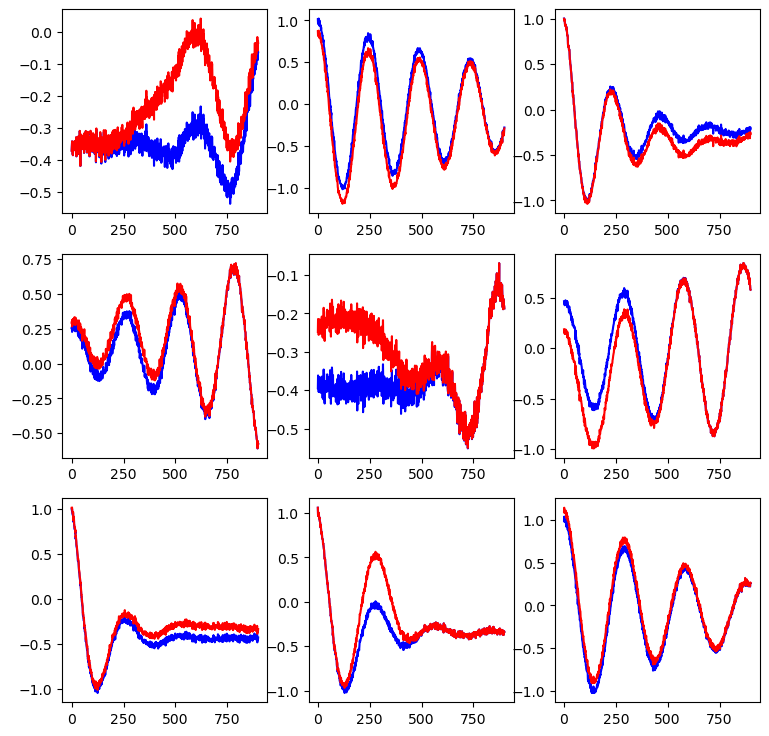

In [15]:
# Examples of mutation

fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize = (9,9))
dummy_inds = np.random.choice(np.arange(len(X0)), size = 9)

for i, ax in enumerate(ax.flat):
    id = dummy_inds[i]
    ax.plot(X0[id], c = 'b')
    
    child = ga.mutation(id)
    ax.plot(child, c = 'r')

# Future Generations

In [16]:
gens_arr = np.zeros(len(X0))
inputs, outputs_abs = X0, y0_abs
dkl_BO, pred_key = dkl_BO_0, rng_key_predict_0
data_gens = {}
niter = 20


for iter in range(niter):
    
    ga = GA(inputs, outputs_abs, dkl_BO, pred_key, gens_arr)

    inputs, outputs_abs, gens_arr = ga.make_next_gen(policy = 'variance')  # Making next generation curves

    # Initialization for the DKL algorithm

    idx = np.where(~np.isnan(outputs_abs))[0]   # Here we will use the curves from the previous generation as the initialization step

    print("The number of intialization points in generation-", iter+1, len(idx))
          
    inputs_train = inputs[idx]
    inputs_unmeasured = np.delete(inputs, idx, axis=0)
    
    indices_total = np.arange(len(inputs))
    indices_train = indices_total[idx]
    y_train = outputs_abs[idx]
    indices_unmeasured = np.delete(indices_total, idx)

    exploration_steps = 10
    for e in range(exploration_steps):
        print("\nStep {}".format(e+1))
        # Obtain/update DKL posterior
        rng_key, pred_key = gpax.utils.get_keys()
        dkl_BO = gpax.viDKL(900, 2, 'RBF')
        dkl_BO.fit(rng_key, inputs_train, y_train, nn = CustomCNN, num_steps = 10000, step_size = 5e-4)
        # Compute acqusition function
        y_mean, y_var = dkl_BO.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
            pred_key, inputs_unmeasured, batch_size=250)
        y_std = jnp.sqrt(y_var)
        obj = y_mean + 10 * y_std  # UCB = mu + 10 * sigma
    
        sort = np.argsort(obj)[::-1]
        # Get the next 5 points to evaluate
        ids_next = sort[0:1]
    
        x_next = inputs_unmeasured[ids_next]
        inds_next = indices_unmeasured[ids_next]
        
        
        # run simulation to get the ground truth
        
        # Parallelize using Joblib
        # y_measured = np.array(Parallel(n_jobs=1, backend = 'loky')(delayed(runferrosim)(i, inputs) for i in inds_next))

        y_measured = runferrosim(inds_next[0], inputs)
    
        outputs_abs[inds_next] = y_measured
    
        # Update training arrays
        inputs_train = np.append(inputs_train, x_next, axis=0)
        y_train = np.append(y_train, y_measured)
        inputs_unmeasured = np.delete(inputs_unmeasured, ids_next, axis=0)
        indices_unmeasured = np.delete(indices_unmeasured, ids_next)

    pred_mean, pred_std = dkl_BO.predict(pred_key, inputs)
    pred_mean, pred_std = np.array(pred_mean), np.array(pred_std)
    data_gens[iter] = {}
    data_gens[iter]['X'] = inputs
    data_gens[iter]['y_abs'] = outputs_abs
    data_gens[iter]['X_train'] = inputs_train
    data_gens[iter]['y_train'] = y_train
    data_gens[iter]['X_unmeasured'] = inputs_unmeasured
    data_gens[iter]['indices_unmeasured'] = indices_unmeasured
    data_gens[iter]['gens'] = gens_arr
    data_gens[iter]['pred_mean'] = pred_mean
    data_gens[iter]['pred_std'] = pred_std

with open('allgens_data_policy2_variance_take2.pickle', 'wb') as handle:
    pickle.dump(data_gens, handle, protocol=pickle.HIGHEST_PROTOCOL)

The number of intialization points in generation- 1 150

Step 1


100%|█| 10000/10000 [00:47<00:00, 208.58it/s, init loss: 63112.5710, avg. loss [



Inferred GP kernel parameters
k_length         [3.1092 3.9195]
k_scale          16.7213
noise            0.0204
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.70it/s]



Step 2


100%|█| 10000/10000 [00:46<00:00, 215.79it/s, init loss: 63121.8420, avg. loss [



Inferred GP kernel parameters
k_length         [3.3281 3.7271]
k_scale          12.549800000000001
noise            0.0227
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.90it/s]



Step 3


100%|█| 10000/10000 [01:02<00:00, 158.88it/s, init loss: 63139.7314, avg. loss [



Inferred GP kernel parameters
k_length         [3.9108 2.1889]
k_scale          18.0642
noise            0.027800000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.83it/s]



Step 4


100%|█| 10000/10000 [01:01<00:00, 163.12it/s, init loss: 63144.8346, avg. loss [



Inferred GP kernel parameters
k_length         [3.7688 5.0557]
k_scale          11.645800000000001
noise            0.0195
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.46it/s]



Step 5


100%|█| 10000/10000 [00:59<00:00, 167.40it/s, init loss: 63176.7221, avg. loss [



Inferred GP kernel parameters
k_length         [3.7784 3.2189]
k_scale          16.6964
noise            0.025
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.27it/s]



Step 6


100%|█| 10000/10000 [00:58<00:00, 170.53it/s, init loss: 63203.5447, avg. loss [



Inferred GP kernel parameters
k_length         [4.3639 2.9202]
k_scale          15.999500000000001
noise            0.0205
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.75it/s]



Step 7


100%|█| 10000/10000 [00:58<00:00, 170.50it/s, init loss: 63244.1991, avg. loss [



Inferred GP kernel parameters
k_length         [3.3449 3.6925]
k_scale          16.3047
noise            0.0198
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.93it/s]



Step 8


100%|█| 10000/10000 [00:59<00:00, 169.41it/s, init loss: 63266.4335, avg. loss [



Inferred GP kernel parameters
k_length         [5.0354 3.6261]
k_scale          12.946200000000001
noise            0.0201
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.13it/s]



Step 9


100%|█| 10000/10000 [01:00<00:00, 164.74it/s, init loss: 63308.1695, avg. loss [



Inferred GP kernel parameters
k_length         [2.5933 4.3658]
k_scale          15.153
noise            0.025
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.60it/s]



Step 10


100%|█| 10000/10000 [01:01<00:00, 162.36it/s, init loss: 63335.1762, avg. loss [



Inferred GP kernel parameters
k_length         [3.2207 3.7219]
k_scale          14.4673
noise            0.029
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.57it/s]


The number of intialization points in generation- 2 28

Step 1


100%|█| 10000/10000 [00:12<00:00, 797.35it/s, init loss: 60737.3066, avg. loss [



Inferred GP kernel parameters
k_length         [0.5469 0.5071]
k_scale          13.8564
noise            0.1085
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.54it/s]



Step 2


100%|█| 10000/10000 [00:12<00:00, 783.68it/s, init loss: 60777.9324, avg. loss [



Inferred GP kernel parameters
k_length         [0.5048 0.5869]
k_scale          13.4539
noise            0.1092
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.86it/s]



Step 3


100%|█| 10000/10000 [00:12<00:00, 784.90it/s, init loss: 60800.7969, avg. loss [



Inferred GP kernel parameters
k_length         [0.8064 0.6941]
k_scale          14.2413
noise            0.09280000000000001
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.90it/s]



Step 4


100%|█| 10000/10000 [00:23<00:00, 430.68it/s, init loss: 60824.7980, avg. loss [



Inferred GP kernel parameters
k_length         [0.7619 0.7513]
k_scale          13.803500000000001
noise            0.1075
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 63.19it/s]



Step 5


100%|█| 10000/10000 [00:12<00:00, 774.45it/s, init loss: 60867.2196, avg. loss [



Inferred GP kernel parameters
k_length         [0.8652 0.7696]
k_scale          13.154200000000001
noise            0.10010000000000001
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.21it/s]



Step 6


100%|█| 10000/10000 [00:22<00:00, 436.95it/s, init loss: 60895.1508, avg. loss [



Inferred GP kernel parameters
k_length         [1.0412 0.9499]
k_scale          13.203700000000001
noise            0.0901
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.56it/s]



Step 7


100%|█| 10000/10000 [00:23<00:00, 419.02it/s, init loss: 60924.9506, avg. loss [



Inferred GP kernel parameters
k_length         [0.9659 0.8817]
k_scale          12.6103
noise            0.0959
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.26it/s]



Step 8


100%|█| 10000/10000 [00:24<00:00, 402.52it/s, init loss: 60936.0693, avg. loss [



Inferred GP kernel parameters
k_length         [1.1094 1.1528]
k_scale          13.34
noise            0.0796
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 63.02it/s]



Step 9


100%|█| 10000/10000 [00:23<00:00, 418.57it/s, init loss: 60970.7278, avg. loss [



Inferred GP kernel parameters
k_length         [1.3337 1.0671]
k_scale          13.8693
noise            0.0761
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.16it/s]



Step 10


100%|█| 10000/10000 [00:24<00:00, 408.63it/s, init loss: 60989.1614, avg. loss [



Inferred GP kernel parameters
k_length         [1.5509 1.4616]
k_scale          13.075600000000001
noise            0.07060000000000001
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.37it/s]


The number of intialization points in generation- 3 17

Step 1


100%|█| 10000/10000 [00:11<00:00, 868.66it/s, init loss: 60515.9293, avg. loss [



Inferred GP kernel parameters
k_length         [0.3921 0.3979]
k_scale          14.4336
noise            0.2622
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.33it/s]



Step 2


100%|█| 10000/10000 [00:11<00:00, 860.93it/s, init loss: 60574.5896, avg. loss [



Inferred GP kernel parameters
k_length         [0.4256 0.3987]
k_scale          14.1903
noise            0.33030000000000004
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.21it/s]



Step 3


100%|█| 10000/10000 [00:11<00:00, 848.65it/s, init loss: 60628.8123, avg. loss [



Inferred GP kernel parameters
k_length         [0.4121 0.3856]
k_scale          13.7109
noise            0.254
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.77it/s]



Step 4


100%|█| 10000/10000 [00:11<00:00, 844.44it/s, init loss: 60645.3636, avg. loss [



Inferred GP kernel parameters
k_length         [0.5296 0.44  ]
k_scale          13.7292
noise            0.23850000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.68it/s]



Step 5


100%|█| 10000/10000 [00:11<00:00, 833.63it/s, init loss: 60673.7517, avg. loss [



Inferred GP kernel parameters
k_length         [0.4448 0.405 ]
k_scale          13.4275
noise            0.2802
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.75it/s]



Step 6


100%|█| 10000/10000 [00:12<00:00, 826.17it/s, init loss: 60694.6045, avg. loss [



Inferred GP kernel parameters
k_length         [0.4768 0.4516]
k_scale          13.2293
noise            0.2245
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.48it/s]



Step 7


100%|█| 10000/10000 [00:12<00:00, 813.13it/s, init loss: 60733.4606, avg. loss [



Inferred GP kernel parameters
k_length         [0.474  0.4278]
k_scale          12.7622
noise            0.2503
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.00it/s]



Step 8


100%|█| 10000/10000 [00:12<00:00, 825.67it/s, init loss: 60772.4784, avg. loss [



Inferred GP kernel parameters
k_length         [0.449  0.4137]
k_scale          12.6803
noise            0.2446
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.90it/s]



Step 9


100%|█| 10000/10000 [00:12<00:00, 792.46it/s, init loss: 60794.9372, avg. loss [



Inferred GP kernel parameters
k_length         [0.5212 0.4871]
k_scale          12.671700000000001
noise            0.2366
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 63.15it/s]



Step 10


100%|█| 10000/10000 [00:12<00:00, 782.29it/s, init loss: 60810.5940, avg. loss [



Inferred GP kernel parameters
k_length         [0.6388 0.5628]
k_scale          12.653400000000001
noise            0.226
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.76it/s]


The number of intialization points in generation- 4 12

Step 1


100%|█| 10000/10000 [00:11<00:00, 894.62it/s, init loss: 60460.7836, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3192]
k_scale          15.042000000000002
noise            0.34090000000000004
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.97it/s]



Step 2


100%|█| 10000/10000 [00:11<00:00, 877.76it/s, init loss: 60488.3689, avg. loss [



Inferred GP kernel parameters
k_length         [0.3643 0.3271]
k_scale          14.8983
noise            0.2697
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.81it/s]



Step 3


100%|█| 10000/10000 [00:11<00:00, 847.89it/s, init loss: 60516.0957, avg. loss [



Inferred GP kernel parameters
k_length         [0.3761 0.3616]
k_scale          14.709100000000001
noise            0.31120000000000003
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.40it/s]



Step 4


100%|█| 10000/10000 [00:11<00:00, 877.41it/s, init loss: 60534.4548, avg. loss [



Inferred GP kernel parameters
k_length         [0.3832 0.3879]
k_scale          15.140400000000001
noise            0.3526
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.01it/s]



Step 5


100%|█| 10000/10000 [00:11<00:00, 877.64it/s, init loss: 60560.7038, avg. loss [



Inferred GP kernel parameters
k_length         [0.3504 0.3768]
k_scale          14.3199
noise            0.2861
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.81it/s]



Step 6


100%|█| 10000/10000 [00:11<00:00, 848.40it/s, init loss: 60583.9396, avg. loss [



Inferred GP kernel parameters
k_length         [0.3579 0.3755]
k_scale          14.6746
noise            0.3043
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.59it/s]



Step 7


100%|█| 10000/10000 [00:11<00:00, 842.15it/s, init loss: 60613.3769, avg. loss [



Inferred GP kernel parameters
k_length         [0.3865 0.378 ]
k_scale          13.983600000000001
noise            0.27590000000000003
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.63it/s]



Step 8


100%|█| 10000/10000 [00:12<00:00, 801.26it/s, init loss: 60627.4205, avg. loss [



Inferred GP kernel parameters
k_length         [0.5025 0.4704]
k_scale          15.262400000000001
noise            0.22840000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.96it/s]



Step 9


100%|█| 10000/10000 [00:12<00:00, 825.57it/s, init loss: 60645.9894, avg. loss [



Inferred GP kernel parameters
k_length         [0.4452 0.4419]
k_scale          15.328800000000001
noise            0.24860000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.03it/s]



Step 10


100%|█| 10000/10000 [00:12<00:00, 818.38it/s, init loss: 60681.9093, avg. loss [



Inferred GP kernel parameters
k_length         [0.4744 0.5033]
k_scale          13.852400000000001
noise            0.2535
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.28it/s]


The number of intialization points in generation- 5 4

Step 1


100%|█| 10000/10000 [00:09<00:00, 1086.34it/s, init loss: 60155.3021, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          9.2689
noise            0.638
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.80it/s]



Step 2


100%|█| 10000/10000 [00:09<00:00, 1066.83it/s, init loss: 60180.2329, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          9.644400000000001
noise            0.6793
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 63.13it/s]



Step 3


100%|█| 10000/10000 [00:09<00:00, 1050.96it/s, init loss: 60208.0219, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          9.9932
noise            0.7977000000000001
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.89it/s]



Step 4


100%|█| 10000/10000 [00:09<00:00, 1028.23it/s, init loss: 60237.5707, avg. loss 



Inferred GP kernel parameters
k_length         [0.3454 0.3679]
k_scale          11.4467
noise            0.27890000000000004
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.75it/s]



Step 5


100%|█| 10000/10000 [00:09<00:00, 1033.83it/s, init loss: 60255.7995, avg. loss 



Inferred GP kernel parameters
k_length         [0.342  0.3679]
k_scale          11.3705
noise            0.26680000000000004
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.76it/s]



Step 6


100%|█| 10000/10000 [00:10<00:00, 927.30it/s, init loss: 60282.2915, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3419]
k_scale          11.1881
noise            0.2723
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.32it/s]



Step 7


100%|█| 10000/10000 [00:11<00:00, 876.47it/s, init loss: 60307.4174, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3405]
k_scale          11.0378
noise            0.2624
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.03it/s]



Step 8


100%|█| 10000/10000 [00:11<00:00, 893.37it/s, init loss: 60332.1064, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3313]
k_scale          10.9395
noise            0.2248
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.98it/s]



Step 9


100%|█| 10000/10000 [00:11<00:00, 898.30it/s, init loss: 60364.6504, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3243]
k_scale          10.7553
noise            0.2311
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.46it/s]



Step 10


100%|█| 10000/10000 [00:11<00:00, 883.51it/s, init loss: 60392.2709, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3299]
k_scale          10.608600000000001
noise            0.23190000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 63.19it/s]


The number of intialization points in generation- 6 6

Step 1


100%|█| 10000/10000 [00:09<00:00, 1043.59it/s, init loss: 60209.4286, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          9.8732
noise            1.3245
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 61.57it/s]



Step 2


100%|█| 10000/10000 [00:09<00:00, 1029.21it/s, init loss: 60238.1857, avg. loss 



Inferred GP kernel parameters
k_length         [0.341  0.3678]
k_scale          12.2835
noise            0.2629
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.29it/s]



Step 3


100%|█| 10000/10000 [00:09<00:00, 1028.08it/s, init loss: 60266.2797, avg. loss 



Inferred GP kernel parameters
k_length         [0.3387 0.3679]
k_scale          12.072700000000001
noise            0.275
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.87it/s]



Step 4


100%|█| 10000/10000 [00:10<00:00, 928.64it/s, init loss: 60297.0964, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3283]
k_scale          11.9275
noise            0.24050000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.15it/s]



Step 5


100%|█| 10000/10000 [00:10<00:00, 909.09it/s, init loss: 60326.3828, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3309]
k_scale          11.662500000000001
noise            0.2494
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.36it/s]



Step 6


100%|█| 10000/10000 [00:11<00:00, 892.71it/s, init loss: 60358.2746, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.326 ]
k_scale          11.700600000000001
noise            0.20770000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.62it/s]



Step 7


100%|█| 10000/10000 [00:11<00:00, 904.18it/s, init loss: 60384.3590, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3278]
k_scale          11.4901
noise            0.1985
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.29it/s]



Step 8


100%|█| 10000/10000 [00:11<00:00, 880.79it/s, init loss: 60417.1924, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3257]
k_scale          11.3923
noise            0.20500000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.70it/s]



Step 9


100%|█| 10000/10000 [00:11<00:00, 878.17it/s, init loss: 60445.3882, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3215]
k_scale          10.7827
noise            0.17
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 63.08it/s]



Step 10


100%|█| 10000/10000 [00:11<00:00, 875.48it/s, init loss: 60472.6065, avg. loss [



Inferred GP kernel parameters
k_length         [0.3485 0.3347]
k_scale          10.6881
noise            0.1537
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.74it/s]


The number of intialization points in generation- 7 4

Step 1


100%|█| 10000/10000 [00:09<00:00, 1079.39it/s, init loss: 60158.3256, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          9.4108
noise            0.9289000000000001
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.85it/s]



Step 2


100%|█| 10000/10000 [00:09<00:00, 1066.95it/s, init loss: 60193.2551, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          10.1967
noise            1.566
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 61.56it/s]



Step 3


100%|█| 10000/10000 [00:09<00:00, 1052.19it/s, init loss: 60218.1562, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          10.332500000000001
noise            1.4069
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.86it/s]



Step 4


100%|█| 10000/10000 [00:09<00:00, 1033.06it/s, init loss: 60247.5343, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3125]
k_scale          12.9029
noise            0.22890000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 61.69it/s]



Step 5


100%|█| 10000/10000 [00:09<00:00, 1022.94it/s, init loss: 60267.9596, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3039]
k_scale          12.8396
noise            0.2005
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.09it/s]



Step 6


100%|█| 10000/10000 [00:10<00:00, 934.71it/s, init loss: 60287.2637, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3002]
k_scale          12.6774
noise            0.2018
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.20it/s]



Step 7


100%|█| 10000/10000 [00:10<00:00, 917.25it/s, init loss: 60315.8651, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.2991]
k_scale          12.532
noise            0.18100000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.90it/s]



Step 8


100%|█| 10000/10000 [00:11<00:00, 899.05it/s, init loss: 60356.3595, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3049]
k_scale          13.526200000000001
noise            0.1951
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.15it/s]



Step 9


100%|█| 10000/10000 [00:11<00:00, 900.53it/s, init loss: 60383.0402, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3058]
k_scale          13.2062
noise            0.2068
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.11it/s]



Step 10


100%|█| 10000/10000 [00:11<00:00, 883.51it/s, init loss: 60418.9399, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.2983]
k_scale          12.8186
noise            0.2195
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 61.68it/s]


The number of intialization points in generation- 8 8

Step 1


100%|█| 10000/10000 [00:09<00:00, 1017.41it/s, init loss: 60301.9351, avg. loss 



Inferred GP kernel parameters
k_length         [0.3681 0.3294]
k_scale          14.4981
noise            0.2616
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.41it/s]



Step 2


100%|█| 10000/10000 [00:10<00:00, 922.32it/s, init loss: 60333.0243, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3089]
k_scale          14.285200000000001
noise            0.201
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 60.01it/s]



Step 3


100%|█| 10000/10000 [00:10<00:00, 914.94it/s, init loss: 60361.7108, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3065]
k_scale          13.974200000000002
noise            0.2121
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.52it/s]



Step 4


100%|█| 10000/10000 [00:11<00:00, 896.27it/s, init loss: 60386.4486, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3233]
k_scale          13.8209
noise            0.1857
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 60.25it/s]



Step 5


100%|█| 10000/10000 [00:11<00:00, 894.60it/s, init loss: 60420.3951, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3066]
k_scale          13.592600000000001
noise            0.17020000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.86it/s]



Step 6


100%|█| 10000/10000 [00:11<00:00, 888.66it/s, init loss: 60441.2186, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3029]
k_scale          13.528
noise            0.1615
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 60.52it/s]



Step 7


100%|█| 10000/10000 [00:11<00:00, 891.23it/s, init loss: 60472.5391, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.2916]
k_scale          12.2523
noise            0.1822
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 61.79it/s]



Step 8


100%|█| 10000/10000 [00:11<00:00, 875.59it/s, init loss: 60496.0842, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3095]
k_scale          12.478200000000001
noise            0.1762
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 60.55it/s]



Step 9


100%|█| 10000/10000 [00:11<00:00, 836.20it/s, init loss: 60508.7188, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3307]
k_scale          12.308
noise            0.14880000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.06it/s]



Step 10


100%|█| 10000/10000 [00:11<00:00, 855.64it/s, init loss: 60531.0658, avg. loss [



Inferred GP kernel parameters
k_length         [0.366  0.3696]
k_scale          12.871400000000001
noise            0.1464
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 60.29it/s]


The number of intialization points in generation- 9 7

Step 1


100%|█| 10000/10000 [00:09<00:00, 1037.33it/s, init loss: 60252.4127, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3289]
k_scale          14.8289
noise            0.37720000000000004
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.48it/s]



Step 2


100%|█| 10000/10000 [00:09<00:00, 1031.66it/s, init loss: 60282.4193, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3157]
k_scale          14.5797
noise            0.3103
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.57it/s]



Step 3


100%|█| 10000/10000 [00:10<00:00, 933.77it/s, init loss: 60310.9166, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3078]
k_scale          14.4189
noise            0.2553
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.69it/s]



Step 4


100%|█| 10000/10000 [00:10<00:00, 916.74it/s, init loss: 60343.0276, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.31  ]
k_scale          13.9814
noise            0.26480000000000004
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.81it/s]



Step 5


100%|█| 10000/10000 [00:11<00:00, 903.40it/s, init loss: 60383.5970, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3159]
k_scale          13.9786
noise            0.1836
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.31it/s]



Step 6


100%|█| 10000/10000 [00:10<00:00, 909.40it/s, init loss: 60418.9445, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3076]
k_scale          13.0487
noise            0.19140000000000001
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.79it/s]



Step 7


100%|█| 10000/10000 [00:11<00:00, 894.97it/s, init loss: 60446.2993, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3095]
k_scale          13.5684
noise            0.183
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.68it/s]



Step 8


100%|█| 10000/10000 [00:11<00:00, 894.37it/s, init loss: 60482.0178, avg. loss [



Inferred GP kernel parameters
k_length         [0.3258 0.3464]
k_scale          12.4092
noise            0.19060000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.31it/s]



Step 9


100%|█| 10000/10000 [00:11<00:00, 886.00it/s, init loss: 60506.2229, avg. loss [



Inferred GP kernel parameters
k_length         [0.3274 0.3515]
k_scale          12.6731
noise            0.13570000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.07it/s]



Step 10


100%|█| 10000/10000 [00:11<00:00, 881.63it/s, init loss: 60534.8236, avg. loss [



Inferred GP kernel parameters
k_length         [0.364  0.3185]
k_scale          12.514700000000001
noise            0.1535
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 63.16it/s]


The number of intialization points in generation- 10 8

Step 1


100%|█| 10000/10000 [00:09<00:00, 1035.80it/s, init loss: 60296.6709, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3384]
k_scale          14.4031
noise            0.3003
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 61.87it/s]



Step 2


100%|█| 10000/10000 [00:10<00:00, 938.51it/s, init loss: 60321.2612, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3212]
k_scale          14.2004
noise            0.26630000000000004
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.36it/s]



Step 3


100%|█| 10000/10000 [00:10<00:00, 921.79it/s, init loss: 60365.6677, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3281]
k_scale          14.161800000000001
noise            0.2616
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.02it/s]



Step 4


100%|█| 10000/10000 [00:10<00:00, 911.45it/s, init loss: 60395.4909, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3282]
k_scale          14.0556
noise            0.20090000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.80it/s]



Step 5


100%|█| 10000/10000 [00:11<00:00, 903.14it/s, init loss: 60436.8387, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3217]
k_scale          13.693200000000001
noise            0.1981
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.35it/s]



Step 6


100%|█| 10000/10000 [00:11<00:00, 896.14it/s, init loss: 60465.9971, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.318 ]
k_scale          13.4465
noise            0.2041
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.67it/s]



Step 7


100%|█| 10000/10000 [00:11<00:00, 882.12it/s, init loss: 60493.3157, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3171]
k_scale          12.7683
noise            0.1854
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.94it/s]



Step 8


100%|█| 10000/10000 [00:11<00:00, 882.15it/s, init loss: 60521.2878, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.324 ]
k_scale          13.1856
noise            0.1769
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.81it/s]



Step 9


100%|█| 10000/10000 [00:11<00:00, 835.63it/s, init loss: 60532.4914, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3161]
k_scale          12.4943
noise            0.1777
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.50it/s]



Step 10


100%|█| 10000/10000 [00:11<00:00, 857.21it/s, init loss: 60561.3424, avg. loss [



Inferred GP kernel parameters
k_length         [0.3654 0.3194]
k_scale          12.545200000000001
noise            0.1769
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.26it/s]


The number of intialization points in generation- 11 2

Step 1


100%|█| 10000/10000 [00:09<00:00, 1003.78it/s, init loss: 60122.9283, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          10.813500000000001
noise            0.378
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.34it/s]



Step 2


100%|█| 10000/10000 [00:10<00:00, 988.53it/s, init loss: 60156.5799, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          11.850900000000001
noise            0.7139
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 63.11it/s]



Step 3


100%|█| 10000/10000 [00:09<00:00, 1088.27it/s, init loss: 60185.0853, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          12.0089
noise            0.603
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 63.12it/s]



Step 4


100%|█| 10000/10000 [00:09<00:00, 1063.44it/s, init loss: 60211.8320, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3386]
k_scale          13.244900000000001
noise            0.2772
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.62it/s]



Step 5


100%|█| 10000/10000 [00:09<00:00, 1050.17it/s, init loss: 60231.1340, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3309]
k_scale          13.0283
noise            0.2782
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 63.11it/s]



Step 6


100%|█| 10000/10000 [00:09<00:00, 1036.77it/s, init loss: 60254.5305, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3233]
k_scale          12.8541
noise            0.2574
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.24it/s]



Step 7


100%|█| 10000/10000 [00:09<00:00, 1024.44it/s, init loss: 60286.4721, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.324 ]
k_scale          12.604600000000001
noise            0.2661
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.27it/s]



Step 8


100%|█| 10000/10000 [00:10<00:00, 932.05it/s, init loss: 60314.0000, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3181]
k_scale          12.3751
noise            0.2677
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.69it/s]



Step 9


100%|█| 10000/10000 [00:10<00:00, 924.31it/s, init loss: 60325.8441, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3087]
k_scale          12.309700000000001
noise            0.23
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.72it/s]



Step 10


100%|█| 10000/10000 [00:11<00:00, 894.43it/s, init loss: 60341.0810, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3126]
k_scale          12.171800000000001
noise            0.2124
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 61.96it/s]


The number of intialization points in generation- 12 4

Step 1


100%|█| 10000/10000 [00:09<00:00, 1087.32it/s, init loss: 60176.8475, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3403]
k_scale          13.3694
noise            0.38180000000000003
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.46it/s]



Step 2


100%|█| 10000/10000 [00:09<00:00, 1063.48it/s, init loss: 60201.2044, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3278]
k_scale          13.324900000000001
noise            0.2982
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 61.91it/s]



Step 3


100%|█| 10000/10000 [00:09<00:00, 1049.47it/s, init loss: 60218.5337, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3203]
k_scale          13.138
noise            0.3035
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.89it/s]



Step 4


100%|█| 10000/10000 [00:09<00:00, 1034.21it/s, init loss: 60248.9015, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3227]
k_scale          12.8423
noise            0.3577
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.99it/s]



Step 5


100%|█| 10000/10000 [00:09<00:00, 1024.92it/s, init loss: 60274.1047, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.326 ]
k_scale          12.625200000000001
noise            0.37520000000000003
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.47it/s]



Step 6


100%|█| 10000/10000 [00:10<00:00, 925.77it/s, init loss: 60311.0285, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3262]
k_scale          12.7382
noise            0.337
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.41it/s]



Step 7


100%|█| 10000/10000 [00:10<00:00, 922.56it/s, init loss: 60337.3918, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3237]
k_scale          12.571800000000001
noise            0.3023
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.74it/s]



Step 8


100%|█| 10000/10000 [00:10<00:00, 914.09it/s, init loss: 60388.0760, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3202]
k_scale          13.942300000000001
noise            0.35850000000000004
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.24it/s]



Step 9


100%|█| 10000/10000 [00:10<00:00, 917.41it/s, init loss: 60413.1506, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3246]
k_scale          13.7246
noise            0.3516
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.60it/s]



Step 10


100%|█| 10000/10000 [00:11<00:00, 894.97it/s, init loss: 60440.1547, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3226]
k_scale          14.0021
noise            0.3427
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 61.51it/s]


The number of intialization points in generation- 13 8

Step 1


100%|█| 10000/10000 [00:09<00:00, 1025.45it/s, init loss: 60308.5157, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3151]
k_scale          15.361500000000001
noise            0.32930000000000004
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 63.11it/s]



Step 2


100%|█| 10000/10000 [00:10<00:00, 933.51it/s, init loss: 60333.2367, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3091]
k_scale          14.3595
noise            0.3628
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 61.46it/s]



Step 3


100%|█| 10000/10000 [00:10<00:00, 913.08it/s, init loss: 60375.0653, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3198]
k_scale          14.947000000000001
noise            0.2712
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.24it/s]



Step 4


100%|█| 10000/10000 [00:11<00:00, 906.55it/s, init loss: 60405.7726, avg. loss [



Inferred GP kernel parameters
k_length         [0.368  0.3169]
k_scale          14.5974
noise            0.2756
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.78it/s]



Step 5


100%|█| 10000/10000 [00:11<00:00, 902.47it/s, init loss: 60444.2743, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.2999]
k_scale          14.2551
noise            0.2738
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.62it/s]



Step 6


100%|█| 10000/10000 [00:11<00:00, 891.22it/s, init loss: 60489.5802, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3159]
k_scale          13.404100000000001
noise            0.256
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 63.08it/s]



Step 7


100%|█| 10000/10000 [00:11<00:00, 888.00it/s, init loss: 60513.3319, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.295 ]
k_scale          13.4806
noise            0.22940000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.28it/s]



Step 8


100%|█| 10000/10000 [00:11<00:00, 876.77it/s, init loss: 60532.8507, avg. loss [



Inferred GP kernel parameters
k_length         [0.2851 0.3678]
k_scale          13.9006
noise            0.2046
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.24it/s]



Step 9


100%|█| 10000/10000 [00:11<00:00, 873.53it/s, init loss: 60565.3609, avg. loss [



Inferred GP kernel parameters
k_length         [0.3539 0.3069]
k_scale          13.3583
noise            0.2093
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.56it/s]



Step 10


100%|█| 10000/10000 [00:11<00:00, 850.06it/s, init loss: 60589.7067, avg. loss [



Inferred GP kernel parameters
k_length         [0.3601 0.3352]
k_scale          13.575600000000001
noise            0.19890000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.48it/s]


The number of intialization points in generation- 14 7

Step 1


100%|█| 10000/10000 [00:09<00:00, 1026.00it/s, init loss: 60302.9490, avg. loss 



Inferred GP kernel parameters
k_length         [0.3678 0.3308]
k_scale          16.0181
noise            0.3226
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.46it/s]



Step 2


100%|█| 10000/10000 [00:10<00:00, 957.92it/s, init loss: 60333.8564, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3068]
k_scale          15.6638
noise            0.2735
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 61.69it/s]



Step 3


100%|█| 10000/10000 [00:10<00:00, 935.49it/s, init loss: 60370.6287, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3101]
k_scale          15.3748
noise            0.2195
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.98it/s]



Step 4


100%|█| 10000/10000 [00:10<00:00, 916.59it/s, init loss: 60397.6652, avg. loss [



Inferred GP kernel parameters
k_length         [0.3674 0.3247]
k_scale          14.485000000000001
noise            0.183
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 61.85it/s]



Step 5


100%|█| 10000/10000 [00:11<00:00, 898.82it/s, init loss: 60417.4027, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3118]
k_scale          15.027000000000001
noise            0.18710000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 63.08it/s]



Step 6


100%|█| 10000/10000 [00:11<00:00, 906.86it/s, init loss: 60453.6314, avg. loss [



Inferred GP kernel parameters
k_length         [0.3675 0.3235]
k_scale          14.4998
noise            0.1575
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.21it/s]



Step 7


100%|█| 10000/10000 [00:11<00:00, 894.76it/s, init loss: 60482.3574, avg. loss [



Inferred GP kernel parameters
k_length         [0.2977 0.3657]
k_scale          14.1513
noise            0.1912
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 63.09it/s]



Step 8


100%|█| 10000/10000 [00:11<00:00, 892.46it/s, init loss: 60510.1474, avg. loss [



Inferred GP kernel parameters
k_length         [0.3013 0.3678]
k_scale          14.165600000000001
noise            0.18080000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.70it/s]



Step 9


100%|█| 10000/10000 [00:12<00:00, 829.09it/s, init loss: 60540.3760, avg. loss [



Inferred GP kernel parameters
k_length         [0.3685 0.3034]
k_scale          13.930900000000001
noise            0.1723
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.35it/s]



Step 10


100%|█| 10000/10000 [00:11<00:00, 876.51it/s, init loss: 60557.7383, avg. loss [



Inferred GP kernel parameters
k_length         [0.3677 0.2966]
k_scale          13.3419
noise            0.20090000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 61.78it/s]


The number of intialization points in generation- 15 7

Step 1


100%|█| 10000/10000 [00:09<00:00, 1025.71it/s, init loss: 60302.7209, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3038]
k_scale          15.802200000000001
noise            0.3529
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.58it/s]



Step 2


100%|█| 10000/10000 [00:09<00:00, 1018.53it/s, init loss: 60325.6878, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3045]
k_scale          15.5531
noise            0.32270000000000004
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 63.10it/s]



Step 3


100%|█| 10000/10000 [00:10<00:00, 937.54it/s, init loss: 60354.0603, avg. loss [



Inferred GP kernel parameters
k_length         [0.3695 0.3149]
k_scale          15.4061
noise            0.2758
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.03it/s]



Step 4


100%|█| 10000/10000 [00:10<00:00, 926.13it/s, init loss: 60394.0814, avg. loss [



Inferred GP kernel parameters
k_length         [0.3616 0.3187]
k_scale          14.929300000000001
noise            0.2548
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.73it/s]



Step 5


100%|█| 10000/10000 [00:11<00:00, 907.89it/s, init loss: 60425.3298, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3009]
k_scale          14.584700000000002
noise            0.2642
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.20it/s]



Step 6


100%|█| 10000/10000 [00:11<00:00, 853.43it/s, init loss: 60456.6401, avg. loss [



Inferred GP kernel parameters
k_length         [0.3665 0.3092]
k_scale          14.361600000000001
noise            0.187
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.05it/s]



Step 7


100%|█| 10000/10000 [00:11<00:00, 895.41it/s, init loss: 60481.3419, avg. loss [



Inferred GP kernel parameters
k_length         [0.3224 0.3488]
k_scale          14.784
noise            0.1689
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.85it/s]



Step 8


100%|█| 10000/10000 [00:11<00:00, 868.35it/s, init loss: 60514.8712, avg. loss [



Inferred GP kernel parameters
k_length         [0.3534 0.3262]
k_scale          14.173
noise            0.1824
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 61.96it/s]



Step 9


100%|█| 10000/10000 [00:11<00:00, 873.49it/s, init loss: 60538.5745, avg. loss [



Inferred GP kernel parameters
k_length         [0.3316 0.365 ]
k_scale          13.561100000000001
noise            0.16540000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.59it/s]



Step 10


100%|█| 10000/10000 [00:11<00:00, 873.50it/s, init loss: 60565.3486, avg. loss [



Inferred GP kernel parameters
k_length         [0.3403 0.3482]
k_scale          14.1296
noise            0.1446
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.56it/s]


The number of intialization points in generation- 16 3

Step 1


100%|█| 10000/10000 [00:10<00:00, 982.95it/s, init loss: 60162.3726, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          10.3664
noise            3.7305
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 63.13it/s]



Step 2


100%|█| 10000/10000 [00:09<00:00, 1071.31it/s, init loss: 60183.5956, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          10.3778
noise            3.3242000000000003
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.79it/s]



Step 3


100%|█| 10000/10000 [00:10<00:00, 981.31it/s, init loss: 60209.3460, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          10.674100000000001
noise            2.9319
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 61.99it/s]



Step 4


100%|█| 10000/10000 [00:09<00:00, 1039.22it/s, init loss: 60237.9139, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3278]
k_scale          16.7044
noise            0.42450000000000004
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.71it/s]



Step 5


100%|█| 10000/10000 [00:09<00:00, 1030.17it/s, init loss: 60265.1914, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3136]
k_scale          16.2517
noise            0.3749
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.57it/s]



Step 6


100%|█| 10000/10000 [00:09<00:00, 1016.40it/s, init loss: 60283.9656, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3134]
k_scale          16.072100000000002
noise            0.3668
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.99it/s]



Step 7


100%|█| 10000/10000 [00:10<00:00, 935.16it/s, init loss: 60322.2686, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3136]
k_scale          15.6507
noise            0.33630000000000004
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 61.53it/s]



Step 8


100%|█| 10000/10000 [00:10<00:00, 920.75it/s, init loss: 60350.1746, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3139]
k_scale          15.037
noise            0.29560000000000003
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 61.85it/s]



Step 9


100%|█| 10000/10000 [00:11<00:00, 901.81it/s, init loss: 60365.7017, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3142]
k_scale          15.339500000000001
noise            0.2252
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.64it/s]



Step 10


100%|█| 10000/10000 [00:11<00:00, 905.08it/s, init loss: 60402.6727, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3156]
k_scale          14.9368
noise            0.21430000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.44it/s]


The number of intialization points in generation- 17 6

Step 1


100%|█| 10000/10000 [00:09<00:00, 1040.73it/s, init loss: 60271.8646, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3296]
k_scale          16.0105
noise            0.4354
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 61.60it/s]



Step 2


100%|█| 10000/10000 [00:09<00:00, 1027.55it/s, init loss: 60294.5397, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3365]
k_scale          15.8344
noise            0.3689
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.80it/s]



Step 3


100%|█| 10000/10000 [00:09<00:00, 1023.73it/s, init loss: 60322.6385, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3237]
k_scale          15.4052
noise            0.35500000000000004
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.99it/s]



Step 4


100%|█| 10000/10000 [00:10<00:00, 931.09it/s, init loss: 60363.1214, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3147]
k_scale          14.5065
noise            0.3161
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.73it/s]



Step 5


100%|█| 10000/10000 [00:10<00:00, 919.51it/s, init loss: 60389.5785, avg. loss [



Inferred GP kernel parameters
k_length         [0.3685 0.3233]
k_scale          14.894900000000002
noise            0.2802
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.01it/s]



Step 6


100%|█| 10000/10000 [00:10<00:00, 913.63it/s, init loss: 60418.4553, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3015]
k_scale          14.1323
noise            0.3033
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.42it/s]



Step 7


100%|█| 10000/10000 [00:11<00:00, 898.15it/s, init loss: 60446.8489, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3097]
k_scale          14.2507
noise            0.2611
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 63.02it/s]



Step 8


100%|█| 10000/10000 [00:11<00:00, 881.59it/s, init loss: 60462.0792, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3071]
k_scale          14.2819
noise            0.23450000000000001
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.24it/s]



Step 9


100%|█| 10000/10000 [00:11<00:00, 893.65it/s, init loss: 60490.1538, avg. loss [



Inferred GP kernel parameters
k_length         [0.3664 0.298 ]
k_scale          13.736600000000001
noise            0.2556
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.24it/s]



Step 10


100%|█| 10000/10000 [00:11<00:00, 889.26it/s, init loss: 60512.2457, avg. loss [



Inferred GP kernel parameters
k_length         [0.3682 0.2962]
k_scale          13.712200000000001
noise            0.23900000000000002
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 63.05it/s]


The number of intialization points in generation- 18 8

Step 1


100%|█| 10000/10000 [00:09<00:00, 1026.50it/s, init loss: 60345.5887, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3231]
k_scale          15.4246
noise            0.3004
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.22it/s]



Step 2


100%|█| 10000/10000 [00:10<00:00, 944.13it/s, init loss: 60369.3595, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3133]
k_scale          15.036100000000001
noise            0.3241
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.64it/s]



Step 3


100%|█| 10000/10000 [00:10<00:00, 919.46it/s, init loss: 60401.9789, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3135]
k_scale          14.8245
noise            0.2806
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 59.57it/s]



Step 4


100%|█| 10000/10000 [00:10<00:00, 914.29it/s, init loss: 60432.2173, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3108]
k_scale          14.532300000000001
noise            0.2791
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.80it/s]



Step 5


100%|█| 10000/10000 [00:11<00:00, 904.37it/s, init loss: 60459.9175, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3045]
k_scale          14.0534
noise            0.3073
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.58it/s]



Step 6


100%|█| 10000/10000 [00:11<00:00, 896.74it/s, init loss: 60492.6764, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3084]
k_scale          13.855
noise            0.298
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.66it/s]



Step 7


100%|█| 10000/10000 [00:11<00:00, 895.43it/s, init loss: 60524.7791, avg. loss [



Inferred GP kernel parameters
k_length         [0.3698 0.3069]
k_scale          13.402600000000001
noise            0.2529
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 63.08it/s]



Step 8


100%|█| 10000/10000 [00:11<00:00, 880.99it/s, init loss: 60554.5566, avg. loss [



Inferred GP kernel parameters
k_length         [0.3092 0.3689]
k_scale          13.551200000000001
noise            0.2275
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.43it/s]



Step 9


100%|█| 10000/10000 [00:11<00:00, 879.26it/s, init loss: 60579.1490, avg. loss [



Inferred GP kernel parameters
k_length         [0.3678 0.305 ]
k_scale          13.4205
noise            0.2449
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.33it/s]



Step 10


100%|█| 10000/10000 [00:11<00:00, 859.21it/s, init loss: 60617.4616, avg. loss [



Inferred GP kernel parameters
k_length         [0.356  0.3292]
k_scale          13.2835
noise            0.2225
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.34it/s]


The number of intialization points in generation- 19 4

Step 1


100%|█| 10000/10000 [00:09<00:00, 1073.08it/s, init loss: 60204.6345, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          11.7894
noise            3.7697000000000003
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.62it/s]



Step 2


100%|█| 10000/10000 [00:09<00:00, 1051.36it/s, init loss: 60226.7997, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3374]
k_scale          16.490000000000002
noise            0.5626
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 61.87it/s]



Step 3


100%|█| 10000/10000 [00:09<00:00, 1032.70it/s, init loss: 60249.1137, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3325]
k_scale          16.2325
noise            0.5132
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.85it/s]



Step 4


100%|█| 10000/10000 [00:09<00:00, 1025.81it/s, init loss: 60275.1693, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3147]
k_scale          15.965000000000002
noise            0.45580000000000004
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.03it/s]



Step 5


100%|█| 10000/10000 [00:09<00:00, 1017.18it/s, init loss: 60305.0186, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.314 ]
k_scale          15.6583
noise            0.3932
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.72it/s]



Step 6


100%|█| 10000/10000 [00:10<00:00, 925.46it/s, init loss: 60338.9847, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3154]
k_scale          15.6072
noise            0.2806
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.86it/s]



Step 7


100%|█| 10000/10000 [00:10<00:00, 926.29it/s, init loss: 60367.8743, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3088]
k_scale          15.192400000000001
noise            0.3035
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.89it/s]



Step 8


100%|█| 10000/10000 [00:11<00:00, 903.05it/s, init loss: 60389.7421, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3162]
k_scale          14.989
noise            0.25270000000000004
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.99it/s]



Step 9


100%|█| 10000/10000 [00:10<00:00, 914.78it/s, init loss: 60412.9475, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3326]
k_scale          15.217300000000002
noise            0.2306
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.00it/s]



Step 10


100%|█| 10000/10000 [00:11<00:00, 888.11it/s, init loss: 60441.0673, avg. loss [



Inferred GP kernel parameters
k_length         [0.3578 0.3401]
k_scale          15.196100000000001
noise            0.1938
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.07it/s]


The number of intialization points in generation- 20 4

Step 1


100%|█| 10000/10000 [00:09<00:00, 1081.43it/s, init loss: 60204.6345, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3679]
k_scale          11.7811
noise            3.7702
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.11it/s]



Step 2


100%|█| 10000/10000 [00:09<00:00, 1058.58it/s, init loss: 60225.8009, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3363]
k_scale          16.4195
noise            0.6123000000000001
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.50it/s]



Step 3


100%|█| 10000/10000 [00:09<00:00, 1039.59it/s, init loss: 60250.3247, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.33  ]
k_scale          16.2388
noise            0.5213
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 64.17it/s]



Step 4


100%|█| 10000/10000 [00:09<00:00, 1025.41it/s, init loss: 60291.3360, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3361]
k_scale          15.669400000000001
noise            0.47150000000000003
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.92it/s]



Step 5


100%|█| 10000/10000 [00:09<00:00, 1013.30it/s, init loss: 60310.7205, avg. loss 



Inferred GP kernel parameters
k_length         [0.3679 0.3295]
k_scale          15.299700000000001
noise            0.4354
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.25it/s]



Step 6


100%|█| 10000/10000 [00:10<00:00, 930.49it/s, init loss: 60338.8869, avg. loss [



Inferred GP kernel parameters
k_length         [0.3678 0.3238]
k_scale          15.260900000000001
noise            0.3461
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 62.36it/s]



Step 7


100%|█| 10000/10000 [00:10<00:00, 930.47it/s, init loss: 60365.4495, avg. loss [



Inferred GP kernel parameters
k_length         [0.3679 0.3267]
k_scale          14.914800000000001
noise            0.318
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.93it/s]



Step 8


100%|█| 10000/10000 [00:11<00:00, 900.01it/s, init loss: 60385.4364, avg. loss [



Inferred GP kernel parameters
k_length         [0.3643 0.3237]
k_scale          14.7147
noise            0.2933
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:15<00:00, 63.18it/s]



Step 9


100%|█| 10000/10000 [00:11<00:00, 900.24it/s, init loss: 60410.2247, avg. loss [



Inferred GP kernel parameters
k_length         [0.3676 0.3253]
k_scale          14.5065
noise            0.2982
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.46it/s]



Step 10


100%|█| 10000/10000 [00:11<00:00, 901.01it/s, init loss: 60444.2544, avg. loss [



Inferred GP kernel parameters
k_length         [0.3593 0.3303]
k_scale          14.222700000000001
noise            0.2717
---Performing simulation---


100%|█████████████████████████████████████████| 948/948 [00:14<00:00, 63.35it/s]


In [14]:
with open('allgens_data.pickle', 'rb') as f:
    data_gens_load = pickle.load(f)

In [79]:
for i in data_gens.keys():
    print(np.nanmax(data_gens[i]['y_abs']))

14.91355762717539
15.076147299835771
15.920860362235894
15.920860362235894
15.920860362235894
15.920860362235894
15.920860362235894
15.920860362235894
15.920860362235894
15.952968645514721
15.952968645514721
15.952968645514721
15.952968645514721
15.952968645514721
15.952968645514721
15.952968645514721
15.952968645514721
15.952968645514721
16.598634269168166
16.598634269168166
16.598634269168166
16.598634269168166
16.598634269168166
16.598634269168166
16.598634269168166
16.598634269168166
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188
16.807955989080188


In [84]:
import imageio

# Directory to store images
image_dir = 'plots/'
video_filename = 'generation_video_take2.gif'
bins = np.arange(7, 19, 0.75)
# Create images from plots
for i in data_gens.keys():
    data = data_gens[i]
    plt.figure(figsize=(10, 6))
    plt.hist(y0_abs, bins = bins, color = 'red', alpha = 0.3)
    plt.hist(data['y_abs'], bins=bins, color='blue', alpha=0.5)
    
    plt.xlim([5, 19])
    plt.ylim([0, 80])
    plt.xlabel('Curl')
    plt.ylabel('Counts')
    plt.title(f'Generation {i}')
    plt.grid(True)
    plt.savefig(f"{image_dir}plot_{i:03d}.png", dpi = 300)
    plt.close()

# Create a video from images
with imageio.get_writer(video_filename, mode='I', fps=3) as writer:
    for i in range(len(data_gens.keys())):
        image = imageio.imread(f"{image_dir}plot_{i:03d}.png")
        
        writer.append_data(image)

print("Video creation complete.")


/tmp/ipykernel_2442551/2837739739.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(f"{image_dir}plot_{i:03d}.png")


Video creation complete.


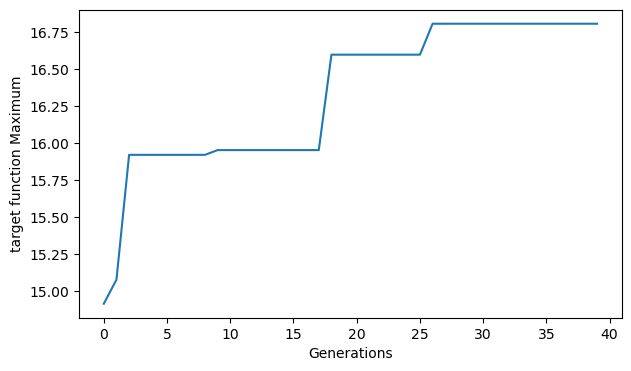

In [85]:
max_values = []
for i in range(40):
    max_values.append(np.nanmax(data_gens[i]['y_abs']))

fig, ax = plt.subplots(figsize = (7,4))
ax.plot(np.arange(40), max_values)
ax.set_xlabel('Generations')
ax.set_ylabel('target function Maximum')

plt.savefig('targetfuncmax_take2.png', dpi = 300)

In [86]:
import imageio

# Directory to store images
image_dir = 'plots/'
video_filename = 'predmean_video_take2.gif'
bins = np.arange(0, 22, 1)
# Create images from plots
for i in data_gens.keys():
    data = data_gens[i]
    plt.figure(figsize=(10, 6))
    plt.hist(y0_abs, bins=bins, color='red', alpha=0.3)
    plt.hist(data['pred_mean'], bins=bins, color='blue', alpha=0.5)
    plt.xlim([5, 18])
    plt.ylim([0, 700])
    plt.xlabel('Curl')
    plt.ylabel('Counts')
    plt.title(f'Generation {i}')
    plt.grid(True)
    plt.savefig(f"{image_dir}fitnessplot_{i:03d}.png", dpi = 300)
    plt.close()

# Create a video from images
with imageio.get_writer(video_filename, mode='I', fps=3) as writer:
    for i in range(len(data_gens.keys())):
        image = imageio.imread(f"{image_dir}fitnessplot_{i:03d}.png")
        
        writer.append_data(image)

print("Video creation complete.")

/tmp/ipykernel_2442551/1205850812.py:25: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(f"{image_dir}fitnessplot_{i:03d}.png")


Video creation complete.


In [203]:
gen = 8
X_train = data_gens[gen]['X_train']
y_train = data_gens[gen]['y_train']
X = data_gens[gen]['X']
y_abs = data_gens[gen]['y_abs']

rng_key, rng_key_predict = gpax.utils.get_keys()
dkl_BO = gpax.viDKL(900, 2, 'RBF')
dkl_BO.fit(rng_key, X_train, y_train, nn = customMLP, num_steps = 3000)

100%|█| 3000/3000 [00:23<00:00, 129.97it/s, init loss: 65452.6827, avg. loss [28



Inferred GP kernel parameters
k_length         [2.3989 1.7028]
k_scale          14.7428
noise            0.11750000000000001


In [206]:
y_mean_train, y_var_train = dkl_BO.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
            rng_key_predict, X_train, batch_size=20)
y_std_train = jnp.sqrt(y_var_train)

y_mean, y_var = dkl_BO.predict_in_batches(  # make prediction batch-by-batch to avoid memory overflow
            rng_key_predict, X, batch_size=20)
y_std = jnp.sqrt(y_var)

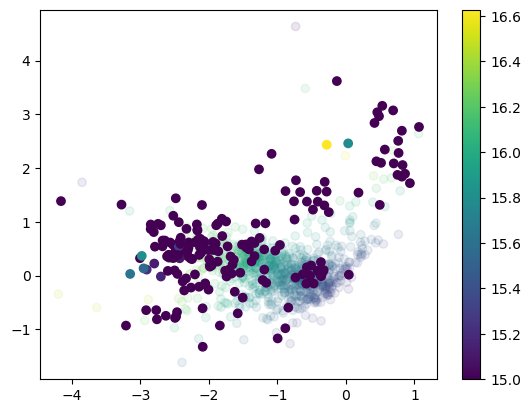

In [207]:
D = dkl_BO.embed(X)
D_train = dkl_BO.embed(X_train)
plt.scatter(D[:,0], D[:, 1], c = y_mean, alpha = 0.1)
plt.scatter(D_train[:,0], D_train[:, 1], c = y_train, vmin = 15)
plt.colorbar()

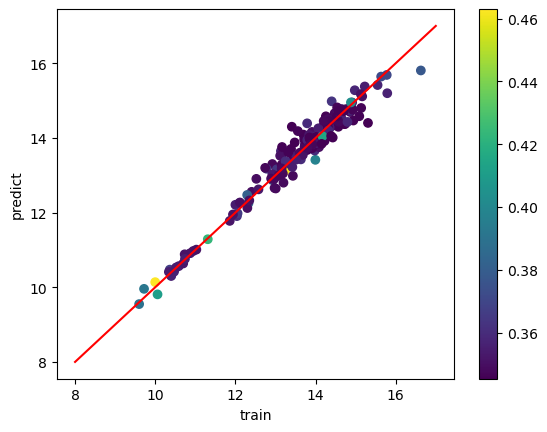

In [208]:
plt.scatter(y_train, y_mean_train, c = y_std_train)
plt.plot(np.linspace(8,17, 100), np.linspace(8,17, 100), c = 'r')
plt.xlabel('train')
plt.ylabel('predict')
plt.colorbar()

In [46]:
np.nanmax(data_gens[9]['y_abs'])

16.368048621781732

/tmp/ipykernel_2480526/1888404665.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(f"{image_dir}plot_{i:03d}.png")


Video creation complete.


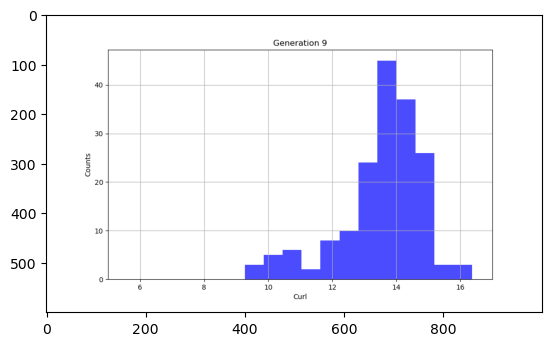

In [30]:
plt.imshow((image))

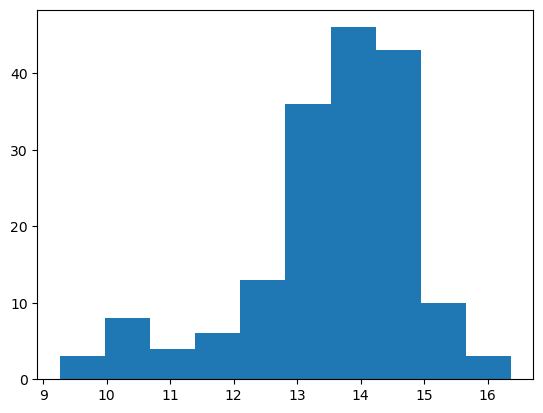

In [37]:
a = plt.hist(data['y_abs'])

NameError: name 'data_gens' is not defined